[학습 목표]
- 데이터 전처리를 배운다.
- 모델을 개선시킨다.

In [34]:
import pandas as pd
import os
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', family='AppleGothic')

In [47]:
in_path = './235745_parking_data/'
train = pd.read_csv(in_path+'train.csv')
test = pd.read_csv(in_path+"test.csv")
sub = pd.read_csv(in_path+"sample_submission.csv")
age = pd.read_csv(in_path+"age_gender_info.csv")

train.shape, test.shape, sub.shape, age.shape

((2952, 15), (1022, 14), (150, 2), (16, 23))

## 결측치 처리

<AxesSubplot:>

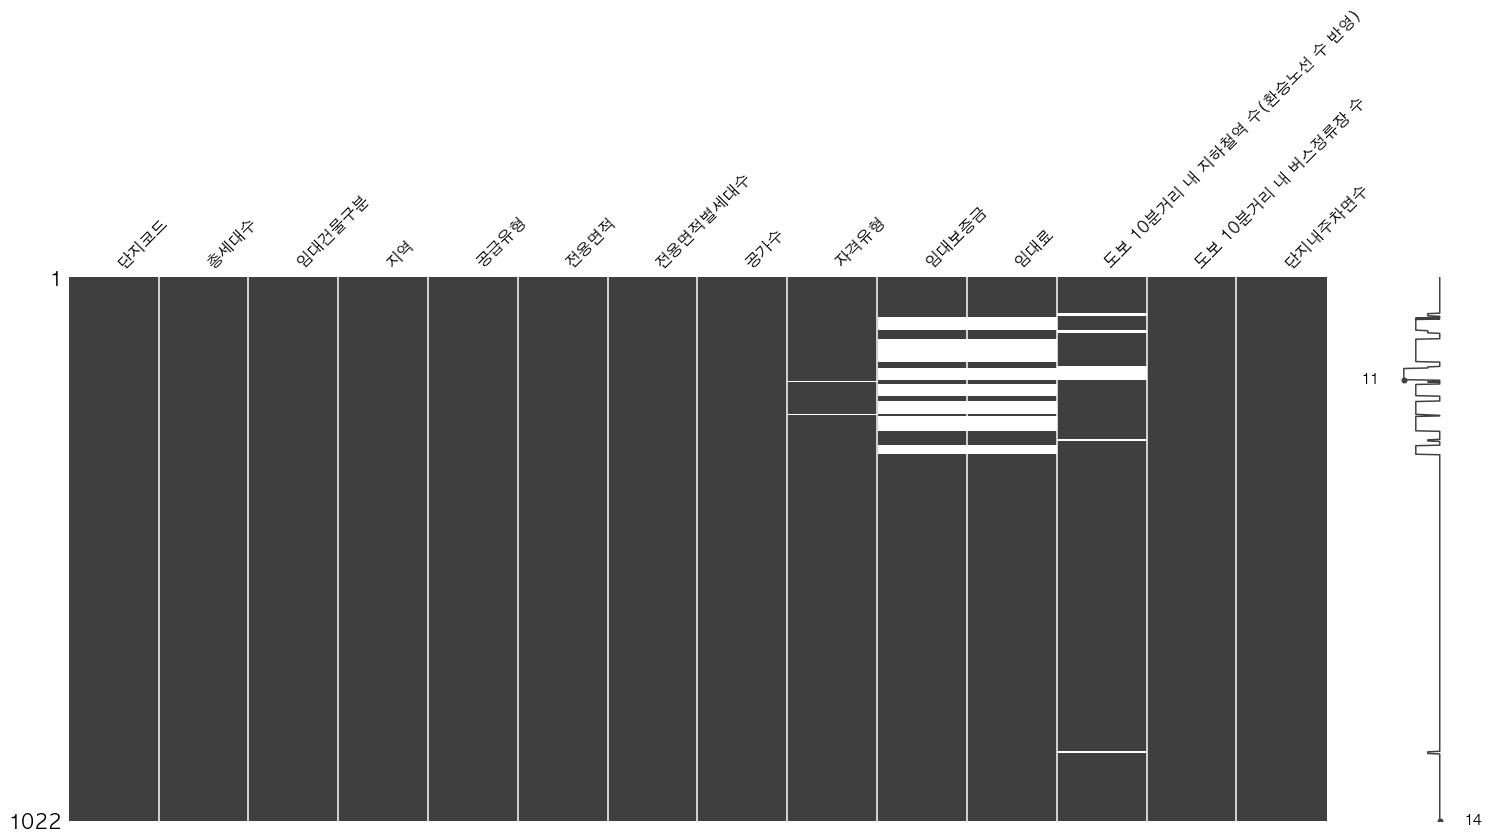

In [36]:
# 시각화
import missingno as msno
msno.matrix(test)
# test.info()

In [48]:
train.columns = ['단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수',
       '자격유형', '임대보증금', '임대료', '10분내지하철수',
       '10분내버스정류장수', '단지내주차면수', '등록차량수']

test.columns = ['단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수',
       '자격유형', '임대보증금', '임대료', '10분내지하철수',
       '10분내버스정류장수', '단지내주차면수']

In [49]:
print(train['지역'].unique())
print(len(train['지역'].unique()))
print(test['지역'].unique())
print(len(test['지역'].unique())) # test에 '서울특별시'가 없다

['경상북도' '경상남도' '대전광역시' '경기도' '전라북도' '강원도' '광주광역시' '충청남도' '부산광역시' '제주특별자치도'
 '울산광역시' '충청북도' '전라남도' '대구광역시' '서울특별시' '세종특별자치시']
16
['경기도' '부산광역시' '전라북도' '경상남도' '충청남도' '대전광역시' '제주특별자치도' '강원도' '울산광역시' '경상북도'
 '충청북도' '광주광역시' '전라남도' '대구광역시' '세종특별자치시']
15


In [50]:
# test 셋 결측치 확인
test.loc[test['자격유형'].isnull()]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,10분내지하철수,10분내버스정류장수,단지내주차면수
196,C2411,962,아파트,경상남도,국민임대,46.90,240,25.0,NaN,71950000,37470,0.0,2.0,840.0
258,C2253,1161,아파트,강원도,영구임대,26.37,745,0.0,NaN,2249000,44770,0.0,2.0,173.0


In [51]:
# train 셋 결측치 확인
train.loc[train['자격유형'].isnull()]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,10분내지하철수,10분내버스정류장수,단지내주차면수,등록차량수


In [52]:
test["자격유형"].unique()

array(['H', 'A', 'E', 'C', 'D', nan, 'G', 'I', 'J', 'K', 'L', 'M', 'N'],
      dtype=object)

In [53]:
# 결측치와 동일한 아파트의 자격유형을 알아보기 위해서 grp1과 grp2로 나눔
grp = test.groupby(['단지코드', '임대건물구분', '지역','공급유형'])
grp1 = grp.get_group( ('C2411', '아파트', '경상남도', '국민임대')  )
grp2 = grp.get_group(('C2253','아파트','강원도','영구임대' ))
grp1

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,10분내지하철수,10분내버스정류장수,단지내주차면수
193,C2411,962,아파트,경상남도,국민임대,39.43,56,25.0,A,11992000,100720,0.0,2.0,840.0
194,C2411,962,아파트,경상남도,국민임대,39.72,336,25.0,A,11992000,100720,0.0,2.0,840.0
195,C2411,962,아파트,경상남도,국민임대,39.82,179,25.0,A,11992000,100720,0.0,2.0,840.0
196,C2411,962,아파트,경상남도,국민임대,46.90,240,25.0,NaN,71950000,37470,0.0,2.0,840.0
197,C2411,962,아파트,경상남도,국민임대,51.93,150,25.0,A,21586000,171480,0.0,2.0,840.0


In [54]:
grp2

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,10분내지하철수,10분내버스정류장수,단지내주차면수
258,C2253,1161,아파트,강원도,영구임대,26.37,745,0.0,NaN,2249000,44770,0.0,2.0,173.0
259,C2253,1161,아파트,강원도,영구임대,31.32,239,0.0,C,3731000,83020,0.0,2.0,173.0
260,C2253,1161,아파트,강원도,영구임대,31.32,149,0.0,C,3731000,83020,0.0,2.0,173.0


In [55]:
test.loc[196,"자격유형"] = "A"
test.loc[258, "자격유형"] = "C"

In [56]:
test.loc[test['자격유형'].isnull()]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,10분내지하철수,10분내버스정류장수,단지내주차면수


<AxesSubplot:>

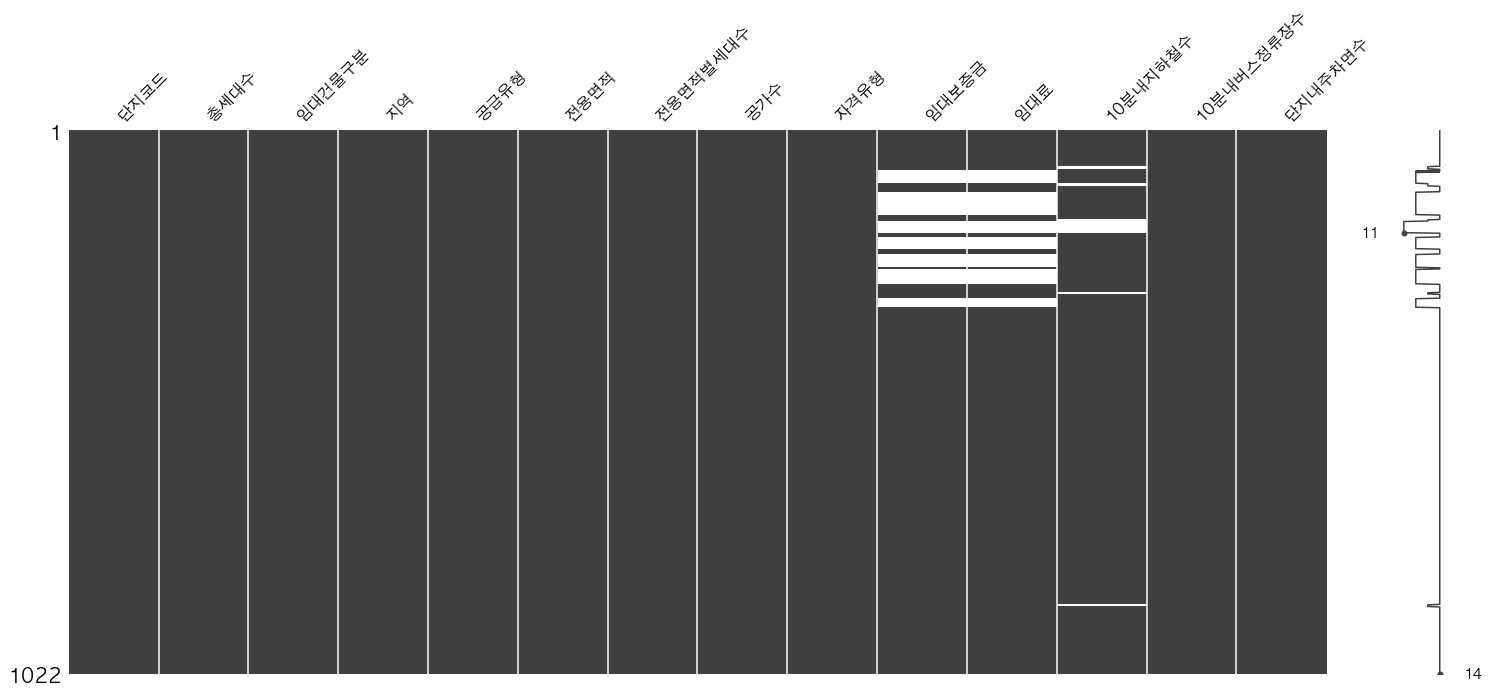

In [45]:
msno.matrix(test)

## 라벨인코딩

In [57]:
print(train.자격유형.unique())
print(test.자격유형.unique())

['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O']
['H' 'A' 'E' 'C' 'D' 'G' 'I' 'J' 'K' 'L' 'M' 'N']


In [58]:
mapping = {'A':1, 'B':2, 'C':3, 'D':4, 'E':5,
           'F':6, 'G':7, 'H':8, 'I':9, 'J':10,
           'K':11, 'L':12, 'M':13, 'N':14, 'O':15}

train['자격유형'] = train["자격유형"].map(mapping).astype('int')
test["자격유형"] = test["자격유형"].map(mapping).astype("int")

train.head(3)

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,10분내지하철수,10분내버스정류장수,단지내주차면수,등록차량수
0,C2483,900,아파트,경상북도,국민임대,39.72,134,38.0,1,15667000,103680,0.0,3.0,1425.0,1015.0
1,C2483,900,아파트,경상북도,국민임대,39.72,15,38.0,1,15667000,103680,0.0,3.0,1425.0,1015.0
2,C2483,900,아파트,경상북도,국민임대,51.93,385,38.0,1,27304000,184330,0.0,3.0,1425.0,1015.0


In [59]:
test.head(3)

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,10분내지하철수,10분내버스정류장수,단지내주차면수
0,C1072,754,아파트,경기도,국민임대,39.79,116,14.0,8,22830000,189840,0.0,2.0,683.0
1,C1072,754,아파트,경기도,국민임대,46.81,30,14.0,1,36048000,249930,0.0,2.0,683.0
2,C1072,754,아파트,경기도,국민임대,46.90,112,14.0,8,36048000,249930,0.0,2.0,683.0


In [60]:
sel = ['총세대수', '전용면적', '전용면적별세대수', '공가수',  '단지내주차면수', '자격유형']
X_train = train[sel]
X_test = test[sel]
y_train = train['등록차량수']

In [61]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_jobs=-1, random_state=42)
model.fit(X_train, y_train)
pred = model.predict(X_test)

In [62]:
test['등록차량수'] = pred
test['단지별차량수평균'] = test.groupby("단지코드")['등록차량수'].transform(np.mean)
test_new = test.drop_duplicates(['단지코드'], keep='first').reset_index()
test_new.head()

,index,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,10분내지하철수,10분내버스정류장수,단지내주차면수,등록차량수,단지별차량수평균
0,0,C1072,754,아파트,경기도,국민임대,39.79,116,14.0,8,22830000,189840,0.0,2.0,683.0,617.45,633.983750
1,8,C1128,1354,아파트,경기도,국민임대,39.79,368,9.0,8,22830000,189840,0.0,3.0,1216.0,1326.24,1346.485556
2,17,C1456,619,아파트,부산광역시,국민임대,33.40,82,18.0,1,19706000,156200,0.0,16.0,547.0,641.40,645.862222
3,26,C1840,593,아파트,전라북도,국민임대,39.57,253,7.0,1,14418000,108130,0.0,3.0,543.0,557.96,559.305000
4,30,C1332,1297,아파트,경기도,국민임대,39.99,282,11.0,8,28598000,203050,0.0,2.0,1112.0,1202.79,1206.192500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,996,C2456,349,아파트,제주특별자치도,국민임대,26.44,24,17.0,8,6992000,117000,0.0,4.0,270.0,226.47,233.892500
146,1000,C1266,596,아파트,충청북도,국민임대,26.94,164,35.0,8,8084000,149910,0.0,1.0,593.0,496.69,497.760000
147,1005,C2152,120,아파트,강원도,영구임대,24.83,66,9.0,3,-,-,0.0,1.0,40.0,37.24,37.600000
148,1007,C1267,675,아파트,경상남도,국민임대,24.87,28,38.0,8,6882000,104370,0.0,1.0,467.0,449.75,450.430909


In [63]:
sub_df = test_new[ ['단지코드', '단지별차량수평균']]
sub_df.columns = ['code', 'num']
sub_df.to_csv('second_rf_0712.csv', index=False)
sub_df.head()

,code,num
0,C1072,633.983750
1,C1128,1346.485556
2,C1456,645.862222
3,C1840,559.305000
4,C1332,1206.192500


> 제출 : *second_rf_0712.csv*  
> 결과 : 138.65787 (315위)

In [64]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
총세대수,2952.0,886.661247,513.540168,26.00,513.50,779.00,1106.0000,2568.0
전용면적,2952.0,44.757215,31.874280,12.62,32.10,39.93,51.5625,583.4
전용면적별세대수,2952.0,102.747967,132.640159,1.00,14.00,60.00,144.0000,1865.0
공가수,2952.0,12.921070,10.778831,0.00,4.00,11.00,20.0000,55.0
자격유형,2952.0,2.950881,3.085250,1.00,1.00,1.00,4.0000,15.0
10분내지하철수,2741.0,0.176578,0.427408,0.00,0.00,0.00,0.0000,3.0
10분내버스정류장수,2948.0,3.695726,2.644665,0.00,2.00,3.00,4.0000,20.0
단지내주차면수,2952.0,601.668360,396.407072,13.00,279.25,517.00,823.0000,1798.0
등록차량수,2952.0,559.768293,433.375027,13.00,220.00,487.00,770.0000,2550.0


## 실습. 라벨인코딩 하나 더 해서 제출

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='지역', ylabel='등록차량수'>

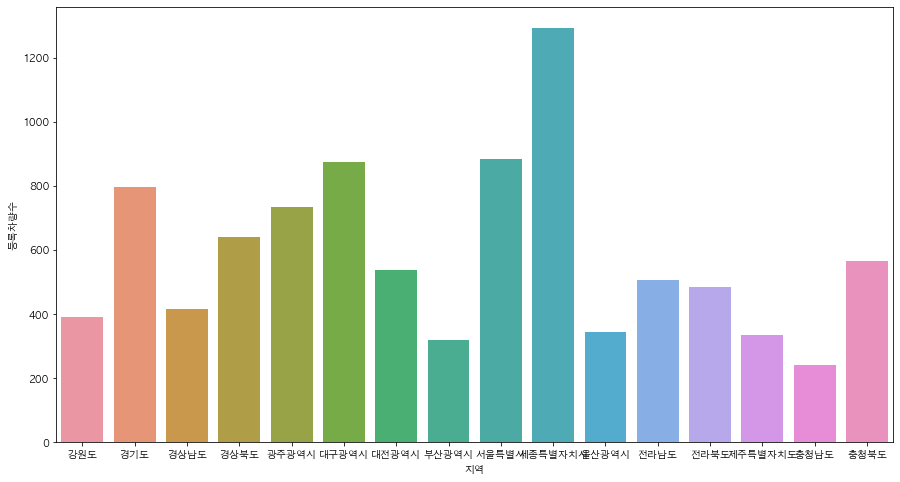

In [72]:
grp_mean = train.groupby("지역").mean()

fig = plt.figure(figsize=(15,8))
sns.barplot(grp_mean.index, grp_mean["등록차량수"]) 

지역별로 등록차량수의 평균 차이가 크지 라벨인코딩시켜서 예측해보자!

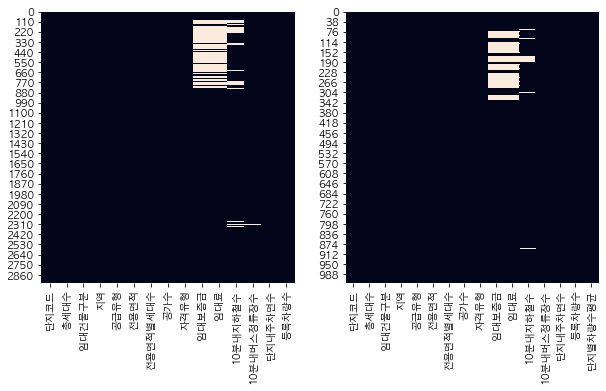

In [90]:
# 결측치 확인
fig = plt.figure(figsize=(10,5))
plt.subplot(121)
sns.heatmap(train.isnull(), cbar=False)
plt.subplot(122)
sns.heatmap(test.isnull(), cbar=False)
plt.show()

In [76]:
print(train.지역.unique())
print(test.지역.unique())

['경상북도' '경상남도' '대전광역시' '경기도' '전라북도' '강원도' '광주광역시' '충청남도' '부산광역시' '제주특별자치도'
 '울산광역시' '충청북도' '전라남도' '대구광역시' '서울특별시' '세종특별자치시']
['경기도' '부산광역시' '전라북도' '경상남도' '충청남도' '대전광역시' '제주특별자치도' '강원도' '울산광역시' '경상북도'
 '충청북도' '광주광역시' '전라남도' '대구광역시' '세종특별자치시']


In [73]:
map_region = {}

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,10분내지하철수,10분내버스정류장수,단지내주차면수,등록차량수
0,C2483,900,아파트,경상북도,국민임대,39.72,134,38.0,1,15667000,103680,0.0,3.0,1425.0,1015.0
1,C2483,900,아파트,경상북도,국민임대,39.72,15,38.0,1,15667000,103680,0.0,3.0,1425.0,1015.0
2,C2483,900,아파트,경상북도,국민임대,51.93,385,38.0,1,27304000,184330,0.0,3.0,1425.0,1015.0


In [91]:
map_region = {'경상북도':1, '경상남도':2, '대전광역시':3, '경기도':4, '전라북도':5,
              '강원도':6, '광주광역시':7, '충청남도':8, '부산광역시':9, '제주특별자치도':10,
            '울산광역시':11, '충청북도':12, '전라남도':13, '대구광역시':14, '서울특별시':15, '세종특별자치시':16}

train["지역"] = train['지역'].map(map_region).astype(int)
test["지역"] = test['지역'].map(map_region).astype(int)

test.head(3)

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,10분내지하철수,10분내버스정류장수,단지내주차면수,등록차량수,단지별차량수평균
0,C1072,754,아파트,4,국민임대,39.79,116,14.0,8,22830000,189840,0.0,2.0,683.0,617.45,633.98375
1,C1072,754,아파트,4,국민임대,46.81,30,14.0,1,36048000,249930,0.0,2.0,683.0,626.47,633.98375
2,C1072,754,아파트,4,국민임대,46.90,112,14.0,8,36048000,249930,0.0,2.0,683.0,623.67,633.98375


In [92]:
train.head(3)

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,10분내지하철수,10분내버스정류장수,단지내주차면수,등록차량수
0,C2483,900,아파트,1,국민임대,39.72,134,38.0,1,15667000,103680,0.0,3.0,1425.0,1015.0
1,C2483,900,아파트,1,국민임대,39.72,15,38.0,1,15667000,103680,0.0,3.0,1425.0,1015.0
2,C2483,900,아파트,1,국민임대,51.93,385,38.0,1,27304000,184330,0.0,3.0,1425.0,1015.0


In [93]:
sel = ['총세대수', '전용면적', '전용면적별세대수', '공가수',  '단지내주차면수', '자격유형',"지역"]
X_train = train[sel]
X_test = test[sel]
y_train = train['등록차량수']

In [94]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_jobs=-1, random_state=42)
model.fit(X_train, y_train)
pred = model.predict(X_test)

In [95]:
test['등록차량수'] = pred
test['단지별차량수평균'] = test.groupby("단지코드")['등록차량수'].transform(np.mean)
test_new = test.drop_duplicates(['단지코드'], keep='first').reset_index()
test_new.head()

,index,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,10분내지하철수,10분내버스정류장수,단지내주차면수,등록차량수,단지별차량수평균
0,0,C1072,754,아파트,4,국민임대,39.79,116,14.0,8,22830000,189840,0.0,2.0,683.0,652.03,661.125000
1,8,C1128,1354,아파트,4,국민임대,39.79,368,9.0,8,22830000,189840,0.0,3.0,1216.0,1329.89,1333.010000
2,17,C1456,619,아파트,9,국민임대,33.40,82,18.0,1,19706000,156200,0.0,16.0,547.0,623.69,631.208889
3,26,C1840,593,아파트,5,국민임대,39.57,253,7.0,1,14418000,108130,0.0,3.0,543.0,534.11,531.542500
4,30,C1332,1297,아파트,4,국민임대,39.99,282,11.0,8,28598000,203050,0.0,2.0,1112.0,1212.73,1205.167500


In [96]:
sub_df = test_new[ ['단지코드', '단지별차량수평균']]
sub_df.columns = ['code', 'num']
sub_df.to_csv('third_rf_0712.csv', index=False)
sub_df.head()

,code,num
0,C1072,661.125000
1,C1128,1333.010000
2,C1456,631.208889
3,C1840,531.542500
4,C1332,1205.167500


> 제출 : *third_rf_0721.csv*  
> 점수 : 137.84508(305위)

#### 단지코드 중 평균이 맞나? median은 어때?


In [103]:
dat_std = test.groupby("단지코드")['등록차량수'].std().round(1)
dat_mean = test.groupby('단지코드')["등록차량수"].mean().round(1)

m_test = pd.concat([dat_std, dat_mean], axis=1)
m_test.to_csv("test_mean.csv")
m_test 
# 이걸로는 분포를 파악하기는 어렵다...!

,등록차량수,등록차량수
단지코드,,
C1003,2.3,300.3
C1006,4.1,182.7
C1016,17.0,779.8
C1019,2.7,361.3
C1030,0.5,39.2
...,...,...
C2653,22.1,832.0
C2675,20.0,993.3
C2676,1.0,218.3


In [105]:
import sklearn
print(sklearn.__version__)

0.23.2
